In [4]:
!pip uninstall torchaudio

Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/torchaudio-2.5.1+cu121.dist-info/*
    /usr/local/lib/python3.11/dist-packages/torchaudio/*
    /usr/local/lib/python3.11/dist-packages/torio/*
Proceed (Y/n)? y
  Successfully uninstalled torchaudio-2.5.1+cu121


In [1]:
!pip install torch torchmetrics torchvision gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [2]:
import math
import os
import pickle
import re
from collections import defaultdict
from pathlib import Path

import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.text import ROUGEScore
from torchvision import transforms
from torchvision.models import convnext_small
from torchvision.transforms import Normalize, ToPILImage, ToTensor
from transformers import GPT2Tokenizer

In [3]:
os.chdir("/content/drive/MyDrive/Data_Sets")

In [8]:
!unzip flickr-8k.zip

Archive:  flickr-8k.zip
   creating: flickr-8k/
   creating: flickr-8k/images/
  inflating: flickr-8k/images/3314180199_2121e80368.jpg  
  inflating: flickr-8k/images/217838128_1f0a84ddc1.jpg  
  inflating: flickr-8k/images/415118186_64defc96f3.jpg  
  inflating: flickr-8k/images/3429351222_17ae744daf.jpg  
  inflating: flickr-8k/images/3329858093_0ec73f2190.jpg  
  inflating: flickr-8k/images/3173014908_b3e69594b6.jpg  
  inflating: flickr-8k/images/2208631481_3e4a5675e1.jpg  
  inflating: flickr-8k/images/390360326_26f5936189.jpg  
  inflating: flickr-8k/images/3065468339_4955e90fd3.jpg  
  inflating: flickr-8k/images/3092756650_557c5f2d03.jpg  
  inflating: flickr-8k/images/2293149170_38fb2257ea.jpg  
  inflating: flickr-8k/images/3535372414_4c51c86fc4.jpg  
  inflating: flickr-8k/images/3050606344_af711c726c.jpg  
  inflating: flickr-8k/images/3214579977_fa9fb006a6.jpg  
  inflating: flickr-8k/images/2444339090_bf7b3211f4.jpg  
  inflating: flickr-8k/images/492802403_ba5246cfea.jpg

In [4]:
torch.manual_seed(42)
np.random.seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [5]:
torch.cuda.is_available()

True

In [6]:
image_dir = "/content/drive/MyDrive/Data_Sets/flickr-8k/images"
text_dir = "/content/drive/MyDrive/Data_Sets/flickr-8k/text"

captions_df = pd.read_csv(text_dir + "/Flickr8k.token.txt", sep="\t", names=["ref_id", "Caption"])
captions_df["image_name"] = captions_df["ref_id"].apply(lambda x: x.split("#")[0])
captions_df.head(10)

,ref_id,Caption,image_name
0,1067790824_f3cc97239b.jpg#0,A white and black dog and a brown dog in sandy...,1067790824_f3cc97239b.jpg
1,1067790824_f3cc97239b.jpg#1,A woolly dog chases a Doberman on a beach .,1067790824_f3cc97239b.jpg
2,1067790824_f3cc97239b.jpg#2,One dog is chasing another one on the beach .,1067790824_f3cc97239b.jpg
3,1067790824_f3cc97239b.jpg#3,The two large dogs are running through sand .,1067790824_f3cc97239b.jpg
4,1067790824_f3cc97239b.jpg#4,Two large dogs chasing each other at the beach .,1067790824_f3cc97239b.jpg
5,1167669558_87a8a467d6.jpg#0,A man in yellow grimaces .,1167669558_87a8a467d6.jpg
6,1167669558_87a8a467d6.jpg#1,a man wearing a yellow shirt with a dramatic l...,1167669558_87a8a467d6.jpg
7,1167669558_87a8a467d6.jpg#2,The man in the yellow t-shirt is pulling a lar...,1167669558_87a8a467d6.jpg
8,1167669558_87a8a467d6.jpg#3,"There is a man , wearing a yellow shirt , and ...",1167669558_87a8a467d6.jpg
9,1167669558_87a8a467d6.jpg#4,This man is smiling very big at the camera .,1167669558_87a8a467d6.jpg


In [7]:
len(captions_df)

1200

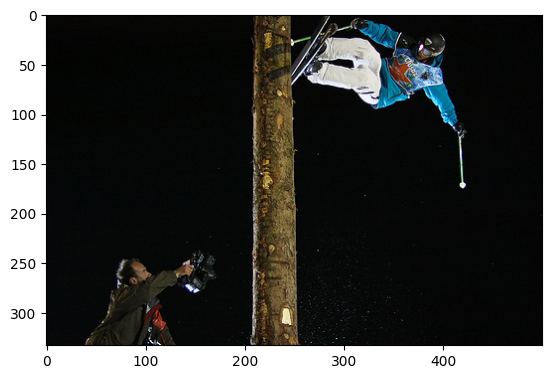

Caption1: A camera man videotapes a skier climbing a tree stump .
Caption2: A man on ski has jumped in a tree while another man is watching
Caption3: A person in skis is jumping off the side of a tree while someone records it .
Caption4: a skier doing a trick on pole while being photographed by another man
Caption5: A skier jumps through the air , next to a tall tree , while a man videotapes him .


In [8]:
images_list = os.listdir(image_dir)
idx = np.random.randint(0, len(os.listdir(image_dir)))
image_name = images_list[idx]

image = Image.open(image_dir + "/" + image_name)
plt.imshow(image)
plt.show()

i = 1
for caption in captions_df[captions_df["image_name"] == image_name]["Caption"]:
    print(f"Caption{i}: {caption}")
    i+=1

In [9]:
class ResizePadTransform:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, image):
        # Calculate the aspect ratio of the original image
        width, height = image.size
        aspect_ratio = width / height

        # Determine the size after resizing while preserving the aspect ratio
        if width > height:
            new_width = self.target_size
            new_height = int(self.target_size / aspect_ratio)
        else:
            new_height = self.target_size
            new_width = int(self.target_size * aspect_ratio)

        # Define a torchvision transform to resize the image
        resize_transform = transforms.Resize((new_height, new_width))

        # Resize the image using the defined transform
        resized_image = resize_transform(image)

        # Calculate the padding required to achieve the target size
        pad_width = self.target_size - new_width
        pad_height = self.target_size - new_height

        # If pad is odd, then it will have issues, so you need to fix it
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top

        # Create a padding transform using torchvision
        padding_transform = transforms.Pad((pad_left, pad_top, pad_right, pad_bottom))

        # Apply the padding transform to the resized image
        padded_resized_image = padding_transform(resized_image)

        return padded_resized_image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

tfms = transforms.Compose([
    ResizePadTransform(224),
    ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens(
    {"bos_token": "<|startoftext|>", "unk_token": "<|unk|>", "pad_token": "[PAD]"}
)

print(tokenizer.encode("A cat is playing."))
print(tokenizer.decode(tokenizer.encode("This is a cat playing.")))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

[32, 3797, 318, 2712, 13]
This is a cat playing.


180 30 30


tensor([50257,   317,  2576,   351,   257,  2266, 14335,   269,   560,   278,
          257,  1256,   286, 17182,   764,   220, 50256, 50259, 50259, 50259,
        50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
        50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
        50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
        50259])


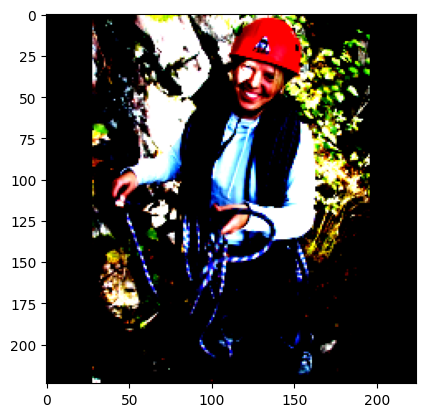

<|startoftext|> A girl with a red helmet carying a lot of rope . <|endoftext|>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, data_split, transform=None, tokenizer=None, max_len=50, phase="train"):
        self.img_folder = Path(root_dir, "images")
        self.text_folder = Path(root_dir, "text")
        split_file = Path(self.text_folder,
                          f"Flickr_8k.{data_split}Images.txt")

        self.images = pd.read_csv(split_file, names=["image_name"])
        self.captions = pd.read_csv(Path(self.text_folder, "Flickr8k.token.txt"),
                                    names=["image_name", "caption"],
                                    sep="\t")

        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.phase = phase

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.phase == "train":
            caption_row = self.captions.iloc[idx]
            caption = caption_row["caption"]
            caption = f"{self.tokenizer.bos_token} {caption} {self.tokenizer.eos_token}"
            caption = self.tokenizer.encode(caption)

            pad_tokens = self.max_len - len(caption) + 1
            caption += pad_tokens * [self.tokenizer.pad_token_id]
            caption = torch.tensor(caption)

            image_name = caption_row["image_name"][:-2]
            image = Image.open(Path(self.img_folder, image_name))
            image = self.transform(image)
        else:
            image_name = self.images["image_name"][idx]
            image = Image.open(Path(self.img_folder, image_name))
            image = self.transform(image)

            caption = self.captions[self.captions["image_name"].str.contains(
                image_name)]["caption"].tolist()

        return {"image": image, "caption": caption, "image_name": image_name}

train_dataset = CustomImageDataset(root_dir = "/content/drive/MyDrive/Data_Sets/flickr-8k", data_split = "train", transform=tfms, tokenizer=tokenizer)
val_dataset = CustomImageDataset(root_dir = "/content/drive/MyDrive/Data_Sets/flickr-8k", data_split = "dev", transform=tfms, tokenizer=tokenizer)
test_dataset = CustomImageDataset(root_dir = "/content/drive/MyDrive/Data_Sets/flickr-8k", data_split = "test", transform=tfms, tokenizer=tokenizer)

print(len(train_dataset), len(val_dataset), len(test_dataset))

print(train_dataset[100]["caption"])
plt.imshow(train_dataset[100]["image"].permute(1, 2, 0))
plt.show()
print(tokenizer.decode(train_dataset[100]["caption"].tolist()))

In [12]:
BATCH_SIZE = 8

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

23
4
4


In [13]:
def get_cnn_model():
    model = convnext_small(
        weights=torchvision.models.convnext.ConvNeXt_Small_Weights.IMAGENET1K_V1)
    model = nn.Sequential(*list(model.children())[:-2])

    return model

model = get_cnn_model()

print(model)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:01<00:00, 200MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, o

In [15]:
# sinusoidal PositionalEncoding class

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)
                             * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [45]:
class TransformerDecoder(nn.Module):
    def __init__(self, emb_size, nhead, num_decoder_layers, tgt_vocab_size, dim_feedforward, dropout, activation):
        super().__init__()
        # Embedding Layer
        self.emb_size = emb_size
        self.embedding = nn.Embedding(tgt_vocab_size, emb_size)
        # Tranformer Decoder Blocks
        self.text_decoder = nn.TransformerDecoder(
                                  nn.TransformerDecoderLayer(
                                      d_model=emb_size,
                                      nhead=nhead,
                                      dim_feedforward=dim_feedforward,
                                      dropout=dropout,
                                      activation=activation
                                    ),
                                  num_layers=num_decoder_layers
                                  )
        # Dense Layer
        self.dense = nn.Linear(emb_size, tgt_vocab_size)
        # add positional encoding
        self.pos_encoder = PositionalEncoding(emb_size, dropout=dropout)
        # initialize weights
        self.init_weights()

    def init_weights(self):
        range = 0.1
        self.embedding.weight.data.uniform_(-range, range)
        self.dense.bias.data.zero_()
        self.dense.weight.data.uniform_(-range, range)

    def forward(self, src_emb, tgt_tokens, tgt_mask, tgt_padding_mask):
        B, D, H, W = src_emb.shape
        src_emb = src_emb.reshape(B, D, -1).permute(2, 0, 1)
        src_emb = self.pos_encoder(src_emb)

        tgt_emb = self.embedding(tgt_tokens) * math.sqrt(self.emb_size)
        tgt_emb = tgt_emb.permute(1, 0, 2)
        tgt_emb = self.pos_encoder(tgt_emb)

        outs = self.text_decoder(
            tgt_emb, src_emb, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask
        )

        return self.dense(outs)

    # For inference
    def predict(self, img_features, tgt_tokens):
        src_emb = self.pos_encoder(img_features)
        tgt_emb = self.embedding(tgt_tokens) * math.sqrt(self.emb_size)
        tgt_emb = tgt_emb.permute(1, 0, 2)
        tgt_emb = self.pos_encoder(tgt_emb)

        outs = self.text_decoder(tgt_emb, src_emb)

        return self.dense(outs)



In [47]:
class CaptionModel(nn.Module):
    def __init__(self, emb_size, nhead, num_decoder_layers, tgt_vocab_size, dim_feedforward, dropout, activation):
        super().__init__()

        self.image_encoder = get_cnn_model()
        self.text_decoder = TransformerDecoder(
                                emb_size,
                                nhead,
                                num_decoder_layers,
                                tgt_vocab_size,
                                dim_feedforward,
                                dropout,
                                activation,
                            )

    def forward(self, img_inp, tgt_tokens, tgt_mask, tgt_padding_mask):
        src_emb = self.image_encoder(img_inp)
        text_out = self.text_decoder(src_emb, tgt_tokens, tgt_mask, tgt_padding_mask)

        return text_out


NUM_LAYERS = 6
EMB_DIM = 768
NHEAD = 8
DIM_FEEDFORWARD = 2048
DROPOUT = 0.1
ACTIVATION = "gelu"


model = CaptionModel(
    emb_size=EMB_DIM,
    nhead=NHEAD,
    num_decoder_layers=NUM_LAYERS,
    tgt_vocab_size=len(tokenizer),
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    activation=ACTIVATION,
)

In [48]:
criterion = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

In [49]:
NUM_EPOCHS = 50
transformer_learning_rate = 1e-4
cnn_learning_rate = 1e-5

optimizer_cnn = torch.optim.AdamW(
    model.image_encoder.parameters(), lr=cnn_learning_rate
)
optimizer_transformer = torch.optim.AdamW(
    model.text_decoder.parameters(), lr=transformer_learning_rate
)

scheduler_cnn = CosineAnnealingLR(optimizer_cnn, T_max=NUM_EPOCHS)
scheduler_transformer = CosineAnnealingLR(optimizer_transformer, T_max=NUM_EPOCHS)

In [50]:
# code to generate a mask for the target to ignore the future sequences

def create_mask(tgt, pad_idx):
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    tgt_padding_mask = (tgt == pad_idx)
    return tgt_mask, tgt_padding_mask


def generate_square_subsequent_mask(sz, device="cuda"):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [52]:
NUM_EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

exp_dir = "training_logs"
writer = SummaryWriter(exp_dir)

checkpoint_epoch = 5

def train():
    for e in range(NUM_EPOCHS):
        model.train()
        train_running_loss = 0.0
        i = 0

        for idx, data in enumerate(train_dataloader):
            imgs = data["image"].to(device=DEVICE)
            target = data["caption"].to(device=DEVICE)

            target_in = target[:, :-1]
            target_out = target[:, 1:]

            model.zero_grad(set_to_none=True)
            tgt_mask, tgt_padding_mask = create_mask(target_in, pad_idx=tokenizer.pad_token_id)

            logits = model(imgs, target_in, tgt_mask.to(DEVICE), tgt_padding_mask.to(DEVICE))

            T, B, D = logits.shape

            loss = criterion(logits.permute(1, 0, 2).reshape(T*B, D), target_out.reshape(T*B))

            writer.add_scalar("loss/train", loss, (e * NUM_EPOCHS + idx))

            loss.backward()
            optimizer_cnn.step()
            optimizer_transformer.step()

            train_running_loss += loss.item()
            i += 1

        scheduler_cnn.step()
        scheduler_transformer.step()

        train_epoch_loss = train_running_loss / i

        writer.add_scalar("epoch_loss/train", train_epoch_loss, e)
        print(f"train loss after epoch {e+1}: {train_epoch_loss}")

        if (e + 1) % checkpoint_epoch == 0:
            model.eval()
            val_running_loss = 0.0
            i = 0

            with torch.no_grad():
                for idx, data in enumerate(val_dataloader):
                    imgs = data["image"].to(device=DEVICE)
                    target = data["caption"].to(device=DEVICE)

                    target_in = target[:, :-1]
                    target_out = target[:, 1:]

                    tgt_mask, tgt_padding_mask = create_mask(target_in, pad_idx=tokenizer.pad_token_id)

                    logits = model(imgs, target_in, tgt_mask.to(DEVICE), tgt_padding_mask.to(DEVICE))

                    T, B, D = logits.shape

                    loss = criterion(logits.permute(1, 0, 2).reshape(T*B, D), target_out.reshape(T*B))

                    val_running_loss += loss.item()
                    i += 1

                val_epoch_loss = val_running_loss / i

                writer.add_scalar("epoch_loss/eval", val_epoch_loss, e)
                print(f"eval loss after epoch {e+1}: {val_epoch_loss}")

            torch.save(model.state_dict(), f"{exp_dir}/model_epoch_{e}.pt")

train()

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


train loss after epoch 1: 1.3765437447506448
train loss after epoch 2: 0.981448100960773
train loss after epoch 3: 0.7076279106347457
train loss after epoch 4: 0.5290075734905575
train loss after epoch 5: 0.4569947214230247
eval loss after epoch 5: 0.2261943444609642
train loss after epoch 6: 0.3971610989259637
train loss after epoch 7: 0.3468968051931132
train loss after epoch 8: 0.317139714308407
train loss after epoch 9: 0.2826388692078383
train loss after epoch 10: 0.2676145058611165
eval loss after epoch 10: 0.20336628705263138
train loss after epoch 11: 0.2550209255322166
train loss after epoch 12: 0.25507500573344855
train loss after epoch 13: 0.22956442897734436
train loss after epoch 14: 0.23812611012355142
train loss after epoch 15: 0.21750787289246268
eval loss after epoch 15: 0.1417006216943264
train loss after epoch 16: 0.212909125763437
train loss after epoch 17: 0.21219583309215048
train loss after epoch 18: 0.20676752989706787
train loss after epoch 19: 0.19729158023129

In [41]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [53]:
model_state = torch.load("/content/drive/MyDrive/Data_Sets/training_logs/model_epoch_49.pt", map_location=DEVICE)
model.load_state_dict(model_state)
model = model.eval()

<ipython-input-53-0ab945ab978a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load("/content/drive/MyDrive/Data_Sets/training_logs/model_epoch_49.pt",

In [56]:
def eval_collate(batch_data):
    images = batch_data[0]["image"].unsqueeze(0)
    caption = batch_data[0]["caption"]
    image_name = batch_data[0]["image_name"]

    data = {"image": images, "caption": caption, "image_name": image_name}

    return data

eval_dataset = CustomImageDataset(
    root_dir="/content/drive/MyDrive/Data_Sets/flickr-8k",
    data_split="test",
    transform=tfms,
    tokenizer=tokenizer,
    phase="test",
)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, collate_fn=eval_collate)

pred_results = defaultdict(list)

model = model.eval()

with torch.no_grad():
    for idx, data in enumerate(eval_dataloader):
        imgs = data["image"].to(DEVICE)
        references = data["caption"]
        image_name = data["image_name"]

        # preprocess captions
        img_ftr = model.image_encoder(imgs).reshape(1, EMB_DIM, -1).permute(2, 0, 1)

        pred_tokens = [tokenizer.bos_token_id]

        while (
            pred_tokens[-1] != tokenizer.eos_token_id
            if len(pred_tokens) > 1
            else True
        ) and len(pred_tokens) <= 50:
            cur_tokens = torch.tensor(pred_tokens).unsqueeze(0).to(DEVICE)
            pred = model.text_decoder.predict(img_ftr, cur_tokens)[-1]

            pred_tokens.append(pred.detach().cpu().argmax(-1).item())

        pred_caption = tokenizer.decode(pred_tokens)

        pred_results["image_name"].append(image_name)
        pred_results["prediction"].append(pred_caption)
        pred_results["references"].append(references)

predictions = [x.replace("<|startoftext|>", "").replace("<|endoftext|>", "") for x in pred_results["prediction"]]
references = pred_results["references"]

rouge_score = ROUGEScore()
rouge_score = rouge_score(predictions, references)["rougeL_fmeasure"]
print(rouge_score)

tensor(0.5214)


In [68]:
def predict(img):
    tokens = [tokenizer.bos_token_id]
    # img = Image.open(img_path).convert("RGB")
    img = tfms(img).unsqueeze(0)
    img = img.to(DEVICE)
    img_ftr = model.image_encoder(img).reshape(1, EMB_DIM, -1).permute(2, 0, 1)
    img_ftr = model.text_decoder.pos_encoder(img_ftr)

    c = 0
    while (
        tokens[-1] != tokenizer.eos_token_id if len(tokens) > 1 else True
    ) and c <= 50:
        pred = model.text_decoder.predict(img_ftr, torch.tensor(tokens, device=DEVICE).unsqueeze(0))[
            -1
        ]
        tokens.append(pred.argmax(-1).item())
        c += 1

    return (
        tokenizer.decode(tokens)
        .replace(tokenizer.bos_token, "")
        .replace(tokenizer.eos_token, "")
        .strip()
    )


image_dir = "/content/drive/MyDrive/Data_Sets/flickr-8k/images"
examples = [
    Path(image_dir, "1377668044_36398401dd.jpg"),
    Path(image_dir, "2094323311_27d58b1513.jpg"),
    Path(image_dir, "299181827_8dc714101b.jpg")
]

model = model.eval()
with torch.no_grad():
    demo = gr.Interface(fn=predict, inputs=gr.Image(
        type="pil"), outputs="text", examples=examples)

    demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0c01239d0179c948dc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
